In [5]:
import gzip
import pickle as pkl


# Function to load all objects from a .pkl.gz file
def load_all(file_path):
    objects = []
    with gzip.open(file_path, 'rb') as f:
        while True:
            try:
                # Load the next pickle object
                objects.append(pkl.load(f))
            except EOFError:
                # End of file reached
                break
    return objects

data = 'CIFAR10'
model = 'resnet50'
n_rounds = 1
nb_epochs = 60
seeds = 1

results_list = []
for active_strategy in [ 'uncertainty', 'random']: #'attack_uncertainty', 'attack', 'margin', 'entropy',
    for size in [1.0, 2.5, 10.0, 25.0]: 
        for seed in range(seeds):
            try:
                file_path = './results/{}_{}_{}_{}_{}_{}_{}.pkl.gz'.format(data, model, active_strategy, n_rounds, size, nb_epochs, seed)
                result = load_all(file_path)[-1]
                result['active_strategy'] = active_strategy
                print(result)
                results_list.append(result)
            except:
                print('issue')
                pass


{'active_strategy': 'uncertainty', 'n_rounds': 1, 'size': 1.0, 'nb_epochs': 60, 'seed': 0, 'data': 'CIFAR10', 'model': 'resnet50', 'init_clean_accuracy': 0.9365000128746033, 'card': 500, 'final_clean_accuracy': 0.6965000033378601, 'final_PGD_accuracy': 0.5058000087738037}
{'active_strategy': 'uncertainty', 'n_rounds': 1, 'size': 2.5, 'nb_epochs': 60, 'seed': 0, 'data': 'CIFAR10', 'model': 'resnet50', 'init_clean_accuracy': 0.9365000128746033, 'card': 1250, 'final_clean_accuracy': 0.7324000000953674, 'final_PGD_accuracy': 0.5346999764442444}
{'active_strategy': 'uncertainty', 'n_rounds': 1, 'size': 10.0, 'nb_epochs': 60, 'seed': 0, 'data': 'CIFAR10', 'model': 'resnet50', 'init_clean_accuracy': 0.9365000128746033, 'card': 5000, 'final_clean_accuracy': 0.7766000032424927, 'final_PGD_accuracy': 0.6035000085830688}
issue
{'active_strategy': 'random', 'n_rounds': 1, 'size': 1.0, 'nb_epochs': 60, 'seed': 0, 'data': 'CIFAR10', 'model': 'resnet50', 'init_clean_accuracy': 0.9365000128746033, 'ca

In [6]:
import pandas as pd
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(results_list)

# Assuming df is your DataFrame
means_stds = df.groupby(['active_strategy', 'size']).agg({
    'final_clean_accuracy': ['mean', 'std' ],
    'final_PGD_accuracy': ['mean', 'std']
})

# Assuming df is your DataFrame
# init_means_stds = df.groupby(['active_strategy', ]).agg({
#     'init_clean_accuracy': ['mean',  'std' ],
#     'init_PGD_accuracy': ['mean',  'std' ],
# })

means_stds.to_csv('./results/means.csv', index=True)

In [7]:
import plotly.graph_objects as go
import pandas as pd

# Load and prepare the data
new_data = pd.read_csv('results/means.csv', skiprows=2)
new_data.columns = ['active_strategy', 'size', 'final_clean_accuracy',
                    'final_clean_accuracy_std', 'final_PGD_accuracy', 'final_PGD_accuracy_std']
new_data['size'] = new_data['size'].astype(int)

for performance in ['PGD_accuracy', 'clean_accuracy' ]:
# performance = 'final_PGD_accuracy' 
# # performance = 'final_clean_accuracy'
    fig = go.Figure()

    # fig.add_trace(go.Scatter(x=[0, 50000], y=[ init_means_stds['init_'+performance]['mean'][0], init_means_stds['init_'+performance]['mean'][0] ],
    #         mode='lines', line=dict(color='rgba({},{},{},1)'.format(0,0,204), width=2, dash='dot'),
    #                     name='Init Accuracy', showlegend=True))


    performance = 'final_'+performance
    performance_std = performance + '_std'  # Corresponding standard deviation column

    strategies = {
        # 'attack_uncertainty': {'color': [204, 0, 204], 'label': 'attack-uncertainty'},  # Red
        # 'full': {'color': [0, 0, 0], 'label': 'full'},  # Red
        'uncertainty': {'color': [255, 161, 90], 'label':'uncertainty'},                    # Yellow
        'random': {'color': [25, 211, 243], 'label':'random'},                    # Cyan
        # 'entropy': {'color': [255, 102, 146], 'label':'entropy'},                  # Magenta
        # 'attack': {'color': [182, 232, 128], 'label':'attack'},                   # Orange
        # 'margin': {'color': [254, 203, 82], 'label':'margin'},
    }


    z_value = 2.576
    n = 5

    # Add a line for each strategy
    for strategy, v in strategies.items():
        r,g,b = v['color']
        c = 'rgba({},{},{},1)'.format(r,g,b)

        # Add a horizontal line for the 'full' strategy
        if strategy == 'full':
            pass
        #     full_data = new_data[new_data['active_strategy'] == 'full']
        #     # Calculate the mean PGD accuracy for the 'full' strategy
        #     full_mean_accuracy = full_data[performance].mean()
        #     fig.add_trace(go.Scatter(x=[min(new_data['size']), max(new_data['size'])], y=[full_mean_accuracy, full_mean_accuracy],
        #                             mode='lines', line=dict(color=c, width=2, dash='dash'),
        #                             name='Full Dataset Average', showlegend=True))
            
        #     strategy_data = new_data[new_data['active_strategy'] == strategy]
        #     fig.add_trace(go.Scatter( x=strategy_data['size'],  y=strategy_data[performance],  mode='lines+markers',
        #                     name=strategy, line=dict(color=c  ) ,
        #                     error_y=dict(
        #                     type='data',  symmetric=False,  
        #                     array=z_value * strategy_data[performance_std] / n,  
        #                     arrayminus=z_value * strategy_data[performance_std] / n   ), showlegend=False
        #                         ))

            
        else:
            strategy_data = new_data[new_data['active_strategy'] == strategy]
            fig.add_trace(go.Scatter(x=strategy_data['size'], y=strategy_data[performance], line=dict(color=c),
                                    error_y=dict(
                                        type='data',  symmetric=False,  
                                        array=z_value * strategy_data[performance_std] / n,  
                                        arrayminus=z_value * strategy_data[performance_std] / n   ),
                                    mode='lines+markers', name=strategy))


    title_str = 'Robust accuracy' if performance=='final_PGD_accuracy' else 'Clean Accuracy'

    # Update layout and display the plot
    fig.update_layout(
        width=600,  # Adjusted for two subplots
        height=400,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=0, r=0, t=50, b=0),
        # title="Box Plot of Datasets by Cases and Columns",
        title=title_str,
        xaxis_title='Size (% of training observations)',
        yaxis_title=title_str,
        legend_title='Data Selection Strategy',
        # yaxis_range=[min(new_data[performance]) - 2, max(new_data[performance]) + 2],
        showlegend=True,
        xaxis=dict(
            # type='log',
            showgrid=True,        # Enable the grid
            gridcolor='lightgray' # Set grid line color
        ),
        yaxis=dict(
            showgrid=True,        # Enable the grid
            gridcolor='lightgray', # Set grid line color
            #range=[75,94] if 'clean' in performance else [45,65]
        )
        )

    # Display the figure
    fig.show()
    fig.write_image("./figures/results_{}_{}_{}_{}_{}.pdf".format(performance, data, model, n_rounds, nb_epochs) )


/home/mheuillet/Desktop/robust_training/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


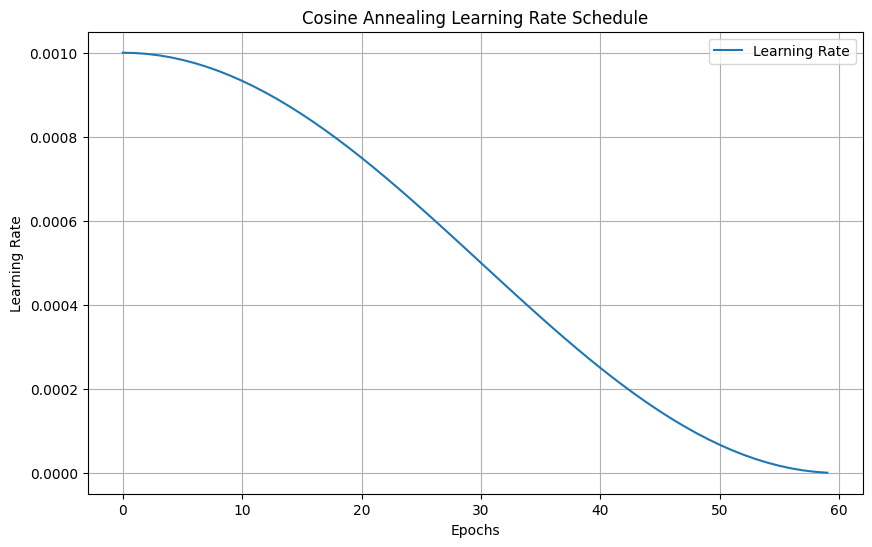

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Hyperparameters
initial_lr = 0.001
num_epochs = 60

# Dummy model and optimizer
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)

# Cosine Annealing Learning Rate Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Store the learning rates for each epoch
lrs = []

for epoch in range(num_epochs):
    # Append the current learning rate to the list
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # Perform a step of the scheduler
    scheduler.step()

# Plotting the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lrs, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()
